In [22]:
from astropy.io import fits
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin
import numpy as np
import math
import hermite
import fitstars
import Gkernel
import utils
import copy
import os
os.environ['MKL_NUM_THREADS'] = '12'

#import imp
#imp.reload(hermite)

## Reading data

#### Read data image

In [23]:
#image_file='1612552p_15C.sub.fits'
image_file='teststar.fits'
#image_file='VIKING/v20100209_00117_st_12_bsub_r.fits'
hdudata = fits.open(image_file)
hdudata.info()
datahdr=hdudata[0].header
dataimage=hdudata[0].data

Filename: teststar.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (2000, 4000)   float64   


#### Read star catalogue

In [59]:
#stars_file='1612552p_15C.sub_shifts.log'
stars_file='teststar.log'
#stars_file='VIKING/v20100209_00117_st_12_bsub_r_star_cat_GAaP.asc'
catstars=np.loadtxt(stars_file,usecols=[2,3,6])  #  this is for CFHT and .log test
#catstars=np.loadtxt(stars_file,usecols=[0,1,2])  #  this is for VIKING test
catstars=catstars[np.where(catstars[:,2] !=0),:][0]  # this removes stars with lensfit weight=0
#catstars[:,0:2]=catstars[:,0:2]-0.5  # adjust for half integer shift in stars position for VIKING test only
catstars=utils.selectstars(dataimage,catstars)  # this filters out stars from user-defined criteria

#### Cleaning the star catalogue

In [60]:
#ncoeff=10
#rgbeta=1.62
#BB=hermite.Bfunc(ncoeff,rgbeta)
#LL=fitstars.chip(dataimage,catstars,BB)
#nstars=len(LL)
#toto=utils.cleanstars(ncoeff,catstars,LL,sigmaval=3)
#np.where(toto)[0],np.invert(toto)
#np.savetxt('accepted.reg',catstars[np.where(np.invert(toto))])
#np.where(np.invert(toto))

#### Read weight image (optional)

In [61]:
#weight_file='1612552p_15C.weight.fits'
#weight_file='v20100210_00246_st_1_bsub_r.weight.fits'
#hdulist = fits.open(weight_file)
#hdulist.info()
#weighthdr=hdulist[0].header
#weightimage=hdulist[0].data
#weightimage[np.where(weightimage != 0)]=1
#dataimage[np.where(weightimage == 0)]=0

## Shapelets formalism

### 1- Definition of the basis functions $B_{nm}$

Take ${\bf r}=(x,y)$, the PSF profile $f({\bf r})$ is given by:

$$
f({\bf r})=\sum_{n=0}^{\rm ncoeff} \sum_{m=0}^{\rm ncoeff} f_{nm} B_n(x;\beta) B_m(y;\beta)
$$

note that there is <code>ncoeff+1</code> coefficients per dimension <code>(0,1,...,ncoeff)</code>. $f_{nm}$ are the shapelet coefficients of profile $f({\bf r})$. $B_n(x;\beta)$ is the one-dimensional Cartesian basis function:

$$
B_n(x;\beta)=\left[2^n \pi^{1\over 2} n!\beta\right]^{-{1\over 2}} H_n\left({x\over \beta}\right)e^{-{x^2\over 2\beta^2}}
$$

where $H_n(x)$ is the physicist Hermite polynomial of order $n$. The parameter $\beta$ is a characteristic scale.

<code>hermite.Bfunc()</code> returns a tuple <code>BB=xx,Bbasis</code>

>        return xx,Bbasis

where <code>BB[0]= xx</code> is the two dimensional $\bf r$ template  of size $\rm (nx,ny)$ and

$$
{\rm BB[1]}={\rm Bbasis}=B_n(x;\beta) B_m(y;\beta)
$$

has size <code>(ncoeff+1,ncoeff+1,nx,ny)</code>. nx, ny and $\beta$ are defined in <code>Bfunc</code>.




#### Find rgbeta (not setup at the moment, rgbeta is set by hand)

In [62]:
#ncoeff=10
#rgbeta=1.62
#BB=hermite.Bfunc(ncoeff,rgbeta)
#LL=fitstars.chip(dataimage,catstars,BB)
#%matplotlib inline
#istar=44
#galrecon=hermite.recon(LL[istar][1],BB)
#plt.imshow(galrecon-LL[istar][0],interpolation="None")
#plt.colorbar()
#sum(map(sum,(galrecon-LL[istar][0])**2))
#indexes=np.random.choice(np.arange(len(catstars)),30)
#hermite.findrgbeta(rgbeta,ncoeff,dataimage,catstars,indexes)
#fmin(hermite.findrgbeta,2.0,(ncoeff,dataimage,catstars,indexes))

In [63]:
ncoeff=10
rgbeta=1.62

In [64]:
%matplotlib inline
BB=hermite.Bfunc(ncoeff,rgbeta)

### 2- Definition of the convolution tensor $C_{\bf nml}$

Consider a star profile $f({\bf r})$, and convolution kernel $g({\bf r})$ and a resulting convolved profile $h({\bf r})$, the observed image is given by the convolution:

$$
h({\bf r})=(f\star g)=\int d{\bf r'} f({\bf r-r'})g({\bf r'})
$$

Let's call ${\bf n}=(n_1,n_2)$, the two-dimensional set of shapelet coefficient indices. Same definition for $\bf m$ and $\bf l$. The shapelet coefficients of $f({\bf r})$ can be written $f_{n_1 n_2}$ or $f_{\bf n}$ alternatively. The shapelet coefficients of the star profile, kernel and convolved profile are related by:

$$
h_{\bf n}=h_{n_1n_2}=\sum_{\bf m,l} C_{\bf nml}f_{\bf m}g_{\bf l}
$$

where $C_{\bf nml}(\gamma,\alpha,\beta)$ is the two-dimensional convolution tensor, which can be written in terms of one-dimensional convolution tensors:

$$
C_{\bf nml}(\gamma,\alpha,\beta)=C_{n_1 m_1 l_1}(\gamma,\alpha,\beta)~C_{n_2 m_2 l_2}(\gamma,\alpha,\beta)
$$

The experssion of the one-dimensional $C_{nml}$ is given by:

$$
C_{nml}(\gamma,\alpha,\beta)=\left(2\pi\right)^{1\over 2}(-1)^n~i^{n+m+l}B^{(3)}_{nml}(\gamma^{-1},\alpha^{-1},\beta^{-1})
$$

where $B^{(3)}_{nml}(a,b,c)$ is given by:

$$
B^{(3)}_{nml}(a,b,c)=\nu \left[2^{n+m+l-1}\pi^{1\over 2} n!~m!~l!~a~b~c\right]^{-{1\over 2}}L_{nml}\left(A,B,C\right)
$$

with the following definitions:

\begin{eqnarray}
\nu^{-2}=a^{-2}+b^{-2}+c^{-2}\\
A=\sqrt{2}~\nu/a \ ; \ \ B=\sqrt{2}~\nu/b \ ; \ \ C=\sqrt{2}~\nu/c
\end{eqnarray}

and the -one-dimensional- $L_{nml}\left(A,B,C\right)$ are given by:

$$
L_{nml}\left(A,B,C\right)={1\over \sqrt{\pi}}\int_{-\infty}^\infty {\rm d}x~e^{-x^2}~H_n(Ax)~H_m(Bx)~H_l(Cx)
$$

There are recursion relations allowing to calculate all the $L_{nml}\left(A,B,C\right)$.

The routine <code>hermite.Cmatrix(ncoeff,g,a,b)</code> calculates the convolution matrix in one-dimension $C_{nml}(\gamma,\alpha,\beta)$ with <code>g</code>=$\gamma$, <code>a</code>=$\alpha$, <code>b</code>=$\beta$. <font color='red'>Note that b and $\beta$ should be the same, TBF later</font>. <code> Cmat</code> has size <code>(ncoeff+1.ncoeff+1,ncoeff+1)</code>

In [65]:
g,a,b=rgbeta,rgbeta,rgbeta
Cmat=hermite.Cmatrix(ncoeff,g,a,b)

## Shapelet analysis of the stars

### 1- Shapelet decomposition of individual stars

For each star in the list, the method <code>fitstars.chip(image_file,stars_file,BB)</code> returns a list <code>LL</code> which contains the elements

<code>LL=[(data for star 1), (data for star 2), ...., (data for star n)]</code>

where <code>LL[i]=(data for star i)</code> corresponds to the i-th star. <code>LL[i]</code> is a tuple containing four sub-elements **which are all numpy arrays**.
<code>LL[i][j]</code> is the j-th sub-element of the i-th star:

<code>LL[i]=(scidata,CC,[x,y],weight)</code>

where

<code>LL[i][0]=scidata</code> is the star profile $f({\bf r})$ centered on star i, its size is $\rm (nx,ny)$. Its size is <code>(ncoeff+1,ncoeff+1)</code>.

<code>LL[i][1]=CC</code> contains the shapelet coefficients of the star i. Its size is <code>(ncoeff+1,ncoeff+1)</code>.

<code>LL[i][2]=[x,y]</code> contains the star position [x,y] on the image in pixel units.

<code>LL[i][3]=weight</code> contains the lensfit weight of the star.

The method <code>fitstars.chip</code> uses <code>hermite.getcoeff(f,BB)</code> to get the shapelet coefficients, where $f({\bf r})$ is the star profile and <code>BB</code> has been calculated above. <code> len(LL)</code> is the number of stars used in the fit.





In [67]:
#  now decompose each star on the BB basis function to get coefficients CC[ncoeff,ncoeff]
LL=fitstars.chip(dataimage,catstars,BB)  ##  returns list with [scidata,CC,[x,y],weight] for each valid stars at [x,y]

### 2- Polynomial fit of the stars shapelet coefficients

Each image has <code>nstars=len(LL)</code> stars with their shapelet coefficients all measured and stored in an array of size <code>(ncoeff+1,ncoeff+1)</code> named <code>LL[i][1]</code> for star <code>i</code>. We now want to estimate how each shapelet coefficient $f_{l_1l_2}(x,y)$ varies across the image as function of position $(x,y)$. We assume that the position variation is described by a 2-dimensional polynomial:

$$
f_{l_1l_2}(x,y)=\sum_{r,s}{\cal C}_{rs}~x^r~y^s
$$

where ${\cal C}_{rs}$ are the, constant, polynomial coefficients. For a second order 2-dimensional polynomial, there are 6 polynomial coefficients. The method <code>fitstars.fittedcoeff(ncoeff,LL)</code> returns the fitted polynomial coefficients, given a known shapelet decomposition <code>LL</code> of all stars. <font color='red'> At this time, the polynomial order and coefficients are set in <code>fitstars.fittedcoeff()</code></font>. 

The method <code>fitstars.fittedcoeff(ncoeff,LL)</code> returns the following tuple of four numpy arrays elements:

<code>oo=(oo[0],oo[1],oo[2],oo[3])</code>

with <code>len(oo[i])=nstars</code> in the number of stars. Each element of the tuple contains the following quantities:

<code>oo[0]</code> is a numpy array $x=[x_0,x_1,....x_N]$ of x-positions of all stars.

<code>oo[1]</code> is a numpy array $y=[y_0,y_1,....y_N]$ of y-positions of all stars.

<code>oo[2]</code> is a numpy array of size <code>(ncoeff+1,ncoeff+1,nstars)</code> containing the input shapelet coefficients of each star.

<code>oo[3]</code> is a numpy array of size <code>(ncoeff+1,ncoeff+1,npoly)</code> contains the polynomial coefficients fitting each shapelet coefficient's variation across the image $(x,y)$. e.g. <code>oo[3][i,j,:]</code> contains the polynomial coefficients of shapelet coefficient <code>(i,j)</code>.

The method <code>fitstars.getcoeff</code> replaces the stars <code>i</code> shapelet coefficients <code>LL[i][1]</code> by their fitted version into <code>LLfit</code>. Everything else in <code>LLfit</code> is the same as in <code>LL</code>

In [68]:
oo=fitstars.fittedcoeff(ncoeff,LL)

In [69]:
LLfit=fitstars.getcoeff(ncoeff,LL,oo)

In [70]:
x = np.arange(0,2200,20)
y = np.arange(0,4400,20)
xx,yy=np.meshgrid(x,y)
zz=fitstars.fittedfunc(xx,yy,oo[3][7,7,:])

In [71]:
#%matplotlib notebook
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(oo[0],oo[1],oo[2][7,7], c='r', marker='o')
#ax.plot_wireframe(xx,yy,zz, rstride=10, cstride=10)

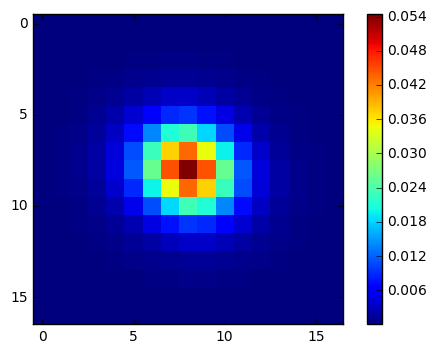

In [72]:
%matplotlib inline
plt.imshow(LL[0][0],interpolation="None")
plt.colorbar()
plt.savefig('initialstar.png')

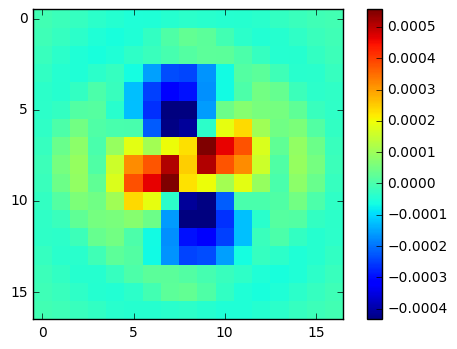

In [73]:
%matplotlib inline
galrecon=hermite.recon(LL[10][1],BB)
plt.imshow(galrecon-LL[10][0],interpolation="None")
plt.colorbar()

### 3- PSF homegeneization process

From Section 2, we want to calculate the kernel shapelet coefficients $k_{m_1m_2}$ such that the resulting stellar profile $h({\bf r})$

$$
h({\bf r})=(f\star k)=\int d{\bf r'} f({\bf r-r'})k({\bf r'})
$$

is the target Gaussian profile:

$$
h({\bf r})=e^{-{{\bf r}^2\over 2\beta^2}}
$$

For each star, the method <code>Gkernel.map(ncoeff,LL,Cmat)</code> calculates the reconvolution kernel coefficients $k_{m_1m_2}$ and the matrix $P_{n_1n_2m_1m_2}$ defined as:

$$
P_{n_1n_2m_1m_2}=\sum_{l_1,l_2} C_{n_1m_1l_1} ~C_{n_2m_2l_2}~f_{l_1l_2}
$$

where $f_{l_1l_2}$ are the star shapelet coefficients. The resulting target PSF $h({\bf r})$ shapelet coefficients $h_{n_1n_2}$ are then given by

$$
h_{n_1n_2}=\sum_{m_1,m_2} P_{n_1n_2m_1m_2}~k_{m_1 m_2}
$$

The arguments of <code>Gkernel.map(ncoeff,LL,Cmat)</code> are <code>ncoeff</code>, <code>LL=fitstars.chip()</code> and <code>Cmat=hermite.Cmatrix()</code>. It returns a list <code>KK</code> which contains the elements:

<code> KK=[(data for star 1),(data for star 2),...(data for star n)]</code>

where <code>KK[i]</code> contains two elements which are **numpy arrays** each:

<code>KK[i][0]=</code>$k_{m_1m_2}$ is the gaussianization kernel shapelet coefficients of the star i. Its size is <code>(ncoeff+1,ncoeff+1)</code>.

<code>KK[i][1]=</code>$P_{n_1n_2m_1m_2}$ is the matrix $P$ for star i as defined above. Its size is <code>(ncoeff+1,ncoeff+1,ncoeff+1,ncoeff+1)</code>.

The mathod <code>Gkernel.getKlist(ncoeff,LL,KK)</code> returns <code>LL</code> where the shapelet coefficients <code>LL[i][1]</code> has been replaced with the gaussianisation kernel coefficients <code>KK[i][0]</code>.

In [74]:
KK=Gkernel.map(ncoeff,LLfit,Cmat)
LK=Gkernel.getKlist(ncoeff,LL,KK)

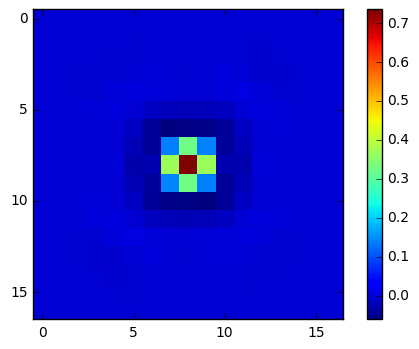

In [75]:
%matplotlib inline
ker=KK[10][0]
ker.shape
kerrecon=hermite.recon(ker,BB)
plt.imshow(kerrecon,interpolation="None")
plt.colorbar()
outfile='kernel.fits'
hdu = fits.PrimaryHDU(kerrecon)
hdu.writeto(outfile, clobber=True)
plt.savefig('kernel.png')

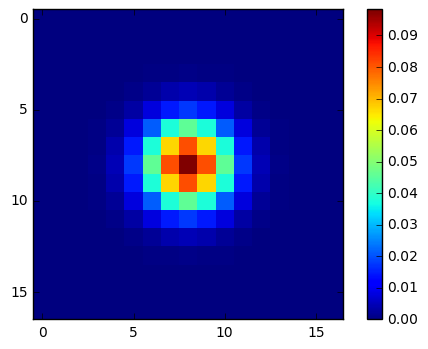

In [76]:
%matplotlib inline
Pmat=KK[10][1]
hnew=Gkernel.convol(ncoeff,Pmat,ker)
hrecon=hermite.recon(hnew,BB)
plt.imshow(hrecon,interpolation="None")
plt.colorbar()
plt.savefig('regauss.png')

In [77]:
#%matplotlib inline
#rad_profile = utils.radial_profile(hrecon, (8,8))
#in_profile = utils.radial_profile(LL[0][0], (8,8))
#plt.plot(rad_profile, 'x-')
#plt.plot(in_profile, 'x-')
#plt.show()

### 3- Polynomial fit of the kernel shapelet coefficients

<code>ooK[3][i,j,k]</code> contains the <code>t-th</code> polynomial coefficient of the <code>(i,j)</code> shapelet coefficient.

In [78]:
ooK=fitstars.fittedcoeff(ncoeff,LK)

## Reconvolving the image

$$
I_{out}(i,j)={\rm Conv}\left[K(x,y;i,j),I_{in}(k,l)\right]
$$

$$
I_{out}(i,j)=\sum_{m,n}~i^mj^n \left[\sum_{a,b} ~k_{a,b;m,n} ~S_{a,b}(x,y)\right]\star I_{in}(x,y)
$$

where we define $T_{mn}(x,y)$ as:

$$
T_{mn}(x,y)=\left[\sum_{a,b} ~k_{a,b;m,n} ~S_{a,b}(x,y)\right]
$$

$k_{a,b;m,n}$ is the kernel shapelet coefficient $(a,b)$ corresponding to the -across the image- polynomial fit coefficients $(m,n)$. Note that the meaning of $(x,y)$ above specify the pixels located around the target position $(i,j)$, NOT the position on the image. Formally, $(m,n)$ can be treated as a single index $q$ so we have in that case:

$$
T_q(x,y)=\left[\sum_{a,b} ~k_{a,b;q} ~S_{a,b}(x,y)\right]
$$

and it becomes clear that $k_{a,b;q}$ is the same as <code>ooK[3][a,b,q]</code>.

In [79]:
Tmat=Gkernel.Tmatrix(ncoeff,ooK,BB)

In [80]:
out=Gkernel.gaussianize(ncoeff,Tmat,dataimage,datahdr)
#out=Gkernel.gaussianize(ncoeff,Tmat,dataimage,datahdr,weight=weightimage)
#plt.imshow(out[1],interpolation='none')
#plt.gca().invert_yaxis()
#plt.colorbar()

Computing weights....


In [81]:
outfile='teststar_gauss.fits'
hdu = fits.PrimaryHDU(out[1])
hdu.header=datahdr
hdu.writeto(outfile, clobber=True)